In [2]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from diffusers import UNet2DModel
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
import torchvision

In [3]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Parameters

We note $\alpha_t=1-\beta_t$ and $\bar{\alpha_t}=\prod_{s=1}^t \alpha_s$

In [4]:
start=0.0001
end=0.02
T=1000
batch_size=8
beta=torch.linspace(start, end, T).to(device)
alpha_bas=torch.cumprod(1.0-beta, dim=0).to(device)

Loading dataset

In [5]:
dts_name="huggan/smithsonian_butterflies_subset"
data=load_dataset(dts_name, split='train')
data

Repo card metadata block was not found. Setting CardData to empty.


Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})

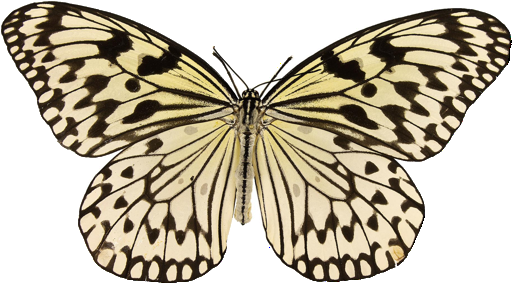

In [6]:
data[0]['image']

Customize dataset

In [7]:
img_size=128
transform=transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
class cus_dts(Dataset):
    def __init__(self, dts, trans):
        self.trans=trans
        self.dts=dts
    def __len__(self):
        return len(self.dts)
    def __getitem__(self, idx):
        img=self.dts[idx]['image']
        img=self.trans(img)
        return img
    

In [10]:
dts=cus_dts(data, transform)
data_loader=DataLoader(dts, batch_size=batch_size)

Visualization

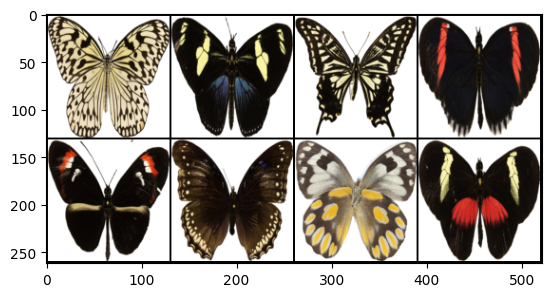

In [11]:
batch=next(iter(data_loader))
grid=torchvision.utils.make_grid(batch, nrow=4)
plt.imshow(grid.permute(1,2,0).cpu().clip(0,1))

Adding noise: Forward process
$$x_t=\sqrt{\bar{\alpha_t}} x_0 +\sqrt{1-\bar{\alpha_t}}N(0,1)$$

In [12]:
def add_noise(img, t):
    noise=torch.randn_like(img).to(device)
    img_noise=torch.sqrt(alpha_bas[t])*img+torch.sqrt(1-alpha_bas[t])*noise
    return img_noise

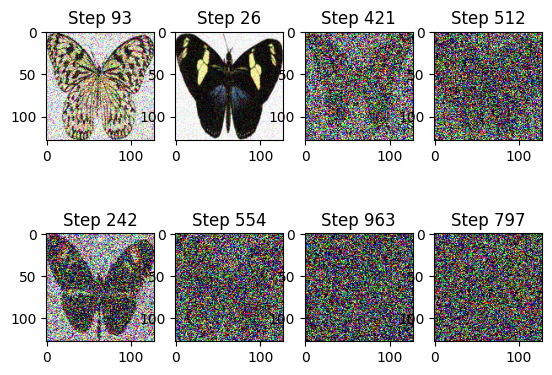

In [13]:
plt.subplots(2,4)
ts_samples=torch.randint(0,T,(8,))#randomly timesteps
#img=add_noise(batch[i].to(device), ts_samples[i])
for i in range(batch.shape[0]):
    img=add_noise(batch[i].to(device), ts_samples[i])# Adding noise
    plt.subplot(2,4,i+1)
    plt.imshow(img.permute(1,2,0).cpu().clip(0,1))
    plt.title(f'Step {ts_samples[i]}')

Loading U_net model from diffusers

In [14]:
model=UNet2DModel(
    sample_size=img_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64,128,128,256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
).to(device)


In [15]:
sum([p.numel() for p in model.parameters()])

18536323

Scheduler

In [17]:
from diffusers import DDPMScheduler
noise_scheduler=DDPMScheduler(num_train_timesteps=1000)
noise_scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.31.0",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

Training

In [18]:
opt=torch.optim.Adam(model.parameters())

In [19]:
n_epoch=21
losses=[]
for epoch in range(n_epoch):
    Loss=0
    for i, batch in enumerate(data_loader):
        imgs=batch.to(device)
        opt.zero_grad()
        ts=torch.randint(0,T, (batch_size,), device=device).long() # A randon number between 1 and T
        eps=torch.randn_like(imgs).to(device) #Noises
        noise_img=noise_scheduler.add_noise(imgs, eps, ts)
        #noise_img=[]
        #for k in range(batch_size):
        #    noise_img.append(add_noise(imgs[k], ts[k]).to(device)) # Adding noise to images
        #noise_img=torch.stack(noise_img, dim=0)
        eps_hat=model(noise_img, ts)['sample'] #Passing the image noise to model
        loss=F.mse_loss(eps_hat.view(-1,1), eps.view(-1,1))
        loss.backward()
        opt.step()
        Loss+=loss
        losses.append(loss.item())
    if epoch%4==0:
        print(f'Epoch {epoch}, Loss: {Loss/len(data_loader)} ')


Epoch 0, Loss: 0.06787548214197159 
Epoch 4, Loss: 0.016805175691843033 
Epoch 8, Loss: 0.017931614071130753 
Epoch 12, Loss: 0.011372667737305164 
Epoch 16, Loss: 0.011757559143006802 
Epoch 20, Loss: 0.010939870029687881 


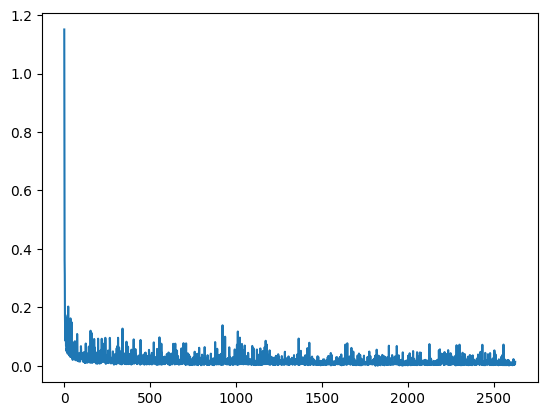

In [21]:
plt.plot(losses)   

In [22]:
torch.save(model,'ddpm_model.pth')

Generate images

In [29]:
noise_scheduler=DDPMScheduler(num_train_timesteps=1000)
noise_scheduler.set_timesteps(num_inference_steps=40)
noise_scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

In [30]:
samples=torch.randn((8,3,128,128), device=device)
for i, t in enumerate(noise_scheduler.timesteps):
    with torch.no_grad():
        res=model(samples,t).sample
    samples=noise_scheduler.step(res,t,samples).prev_sample

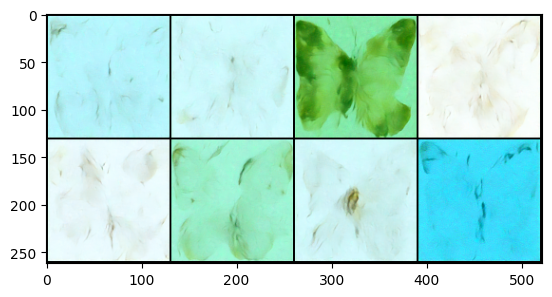

In [31]:
samples_grid=torchvision.utils.make_grid(samples, nrow=4)
plt.imshow(samples_grid.permute(1,2,0).cpu().clip(0,1))

Denoising: Reverse process

In [32]:
def sampling(x,ts_sample):
    alpha=1-torch.linspace(start, end, ts_sample)
    alpha_bas=torch.cumprod(alpha, dim=0)
    model.eval()
    noises=x.to(device)
    with torch.no_grad():
        for t in torch.linspace(ts_sample-1,1, ts_sample-1, device=device).long():
            if t>1:
                z=torch.randn_like(noises) 
            else:
                z=torch.zeros_like(noises)
            coef1=1/torch.sqrt(alpha[t])
            coef2=(1-alpha[t])/(torch.sqrt(1-alpha_bas[t]))
            x_hat=model(noises,t.repeat(batch_size))[0]
            noises=coef1*(noises-coef2*x_hat)+torch.sqrt(beta[t])*z #.unsqueeze(dim=0).repeat(batch_size,1,1,1)
    return noises   

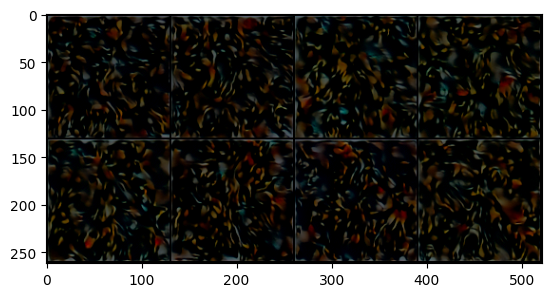

In [33]:
samples=torch.randn((8,3,128,128))
img_pred=sampling(samples.to(device), 40)
img_gd=torchvision.utils.make_grid(img_pred, nrow=4)
plt.imshow(img_gd.permute(1,2,0).cpu().clip(0,1))